In [6]:
from pocket_cube.cube import Cube
from pocket_cube.cube import Move

# %matplotlib notebook

# Creating a scrambled cube 

In [7]:
cube = Cube("F' R U R U F' U'")

## 2D Cube visualization 

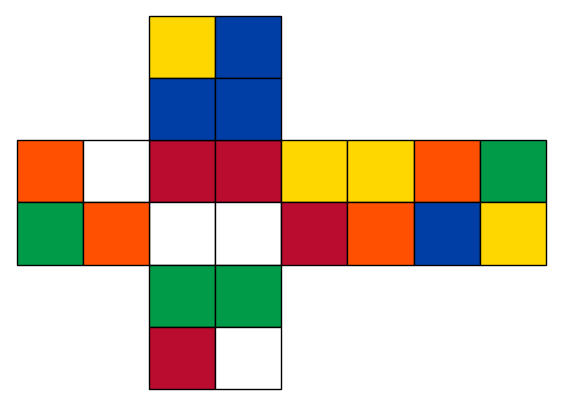

In [8]:
cube.render()

## Text representation 

In [9]:
cube.render_text()

  YB
  BB
OWRRYYOG
GOWWROBY
  GG
  RW


## 3D Cube visualization

For an interactive view of the cube, don't forget to use `%matplotlib notebook`

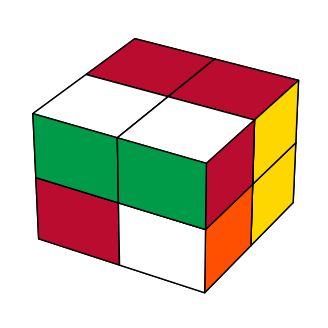

In [10]:
cube.render3D()

# Creating an unscrambled cube 

In [11]:
cube = Cube(scrambled=False)

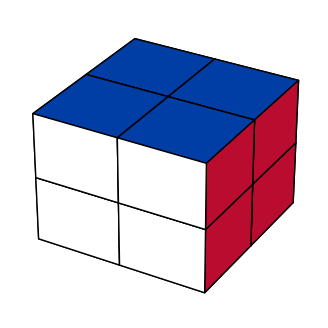

In [12]:
cube.render3D()

## Applying moves on the cube 

In [13]:
cube = cube.move(Move.R)
cube = cube.move(Move.F)

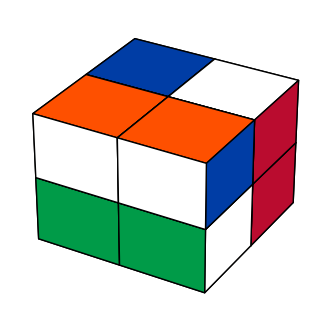

In [14]:
cube.render3D()

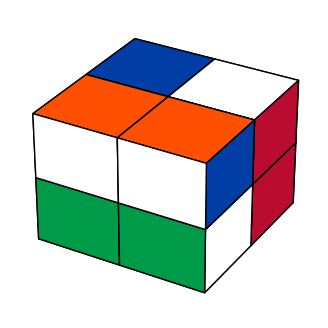

In [15]:
cube.render3D_moves(cube.state, [Move.Fp, Move.Rp])

Pentru rezolvarea cu A* am folosit ca euristica o varianta simplificata a distantei Manhattan care calculeaza numarul de mutari necesar pentru a duce fiecare cubulet la pozitia corecta, fara a lua in considerare si orientarea.
Pentru multimea discovered am folosit tupluri, deoarece numpy.ndarray nu are functie de hash, iar Cube nu are o functie de hash potrivita intrucat doua instante Cube cu state-uri identice nu vor avea acelasi hash.

In [16]:
from itertools import product
from heapq import heappush, heappop
import time

import tests

def get_neighbours(current: Cube, last_move: Move = None):
    return [(move, current.move(move)) for move in Move if move.opposite() != last_move]    

def hamming_distance(a, b):
    return sum(i != j for i, j in zip(a, b))

INDEX_TO_CORNER = {
    ( 0, 13, 18): (0, 1, 1),
    ( 1,  4, 19): (1, 1, 1),
    ( 2, 15, 20): (0, 0, 1),
    ( 3,  6, 21): (1, 0, 1),
    ( 5,  8, 17): (1, 1, 0),
    ( 7, 10, 23): (1, 0, 0),
    ( 9, 12, 16): (0, 1, 0),
    (11, 14, 22): (0, 0, 0),
}

COLOR_TO_INDEX = {
    (0, 1, 5): ( 3,  6, 21),
    (0, 1, 4): ( 1,  4, 19),
    (0, 3, 4): ( 0, 13, 18),
    (0, 3, 5): ( 2, 15, 20),
    (1, 2, 4): ( 5,  8, 17),
    (1, 2, 5): ( 7, 10, 23),
    (2, 3, 4): ( 9, 12, 16),
    (2, 3, 5): (11, 14, 22),
}

CORNER_TO_INDEX = {
    (0, 0, 0): (11, 14, 22),
    (1, 0, 0): ( 7, 10, 23),
    (0, 1, 0): ( 9, 12, 16),
    (1, 1, 0): ( 5,  8, 17),
    (0, 0, 1): ( 2, 15, 20),
    (1, 0, 1): ( 3, 6,  21),
    (0, 1, 1): ( 0, 13, 18),
    (1, 1, 1): ( 1, 4,  19),
}


def manhattan_distance(state):
    val = 0
    for corner in list(product([0, 1], repeat=3)):
        corner_indexes = CORNER_TO_INDEX[corner]
        colors = tuple(sorted(state[i] for i in corner_indexes))
        actual = INDEX_TO_CORNER[COLOR_TO_INDEX[colors]]
        val += hamming_distance(corner, actual)
    return val / 4


def astar(start: Cube, h):
    start_time = time.perf_counter()
    if (start.state == start.goal_state).all():
        return time.perf_counter() - start_time, 1, []

    frontier = []
    heappush(frontier, (0 + h(start.state), start))
    discovered = {tuple(start.state): (None, None, 0)}
    
    goal_state_hash = None
    while frontier:
        node = heappop(frontier)[1]
        node_state_hash = tuple(node.state)
        g_s = discovered[node_state_hash][2]
        for move, neigh in get_neighbours(node, discovered[node_state_hash][1]):
            neigh_state_hash = tuple(neigh.state)
            if neigh_state_hash in discovered and discovered[neigh_state_hash][2] <= g_s + 1:
                continue
            heappush(frontier, (g_s + 1 + h(neigh.state), neigh))
            discovered[neigh_state_hash] = (node_state_hash, move, g_s + 1)
            if (neigh.state == neigh.goal_state).all():
                goal_state_hash = neigh_state_hash
                break
        else:
            continue
        break
    
    path = []
    state_hash = goal_state_hash
    while discovered[state_hash][1] is not None:
        path.append(discovered[state_hash][1])
        state_hash = discovered[state_hash][0]
    
    return time.perf_counter() - start_time, len(discovered), path[::-1]

In [21]:
print('Running A* with manhattan_distance euristic\n')
astar_results = ([], [], [])

elapsed_time, states, solution = astar(Cube(tests.case1), manhattan_distance)
astar_results[0].append(elapsed_time)
astar_results[1].append(states)
astar_results[2].append(len(solution))
print('Testcase 1:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = astar(Cube(tests.case2), manhattan_distance)
astar_results[0].append(elapsed_time)
astar_results[1].append(states)
astar_results[2].append(len(solution))
print('Testcase 2:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = astar(Cube(tests.case3), manhattan_distance)
astar_results[0].append(elapsed_time)
astar_results[1].append(states)
astar_results[2].append(len(solution))
print('Testcase 3:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = astar(Cube(tests.case4), manhattan_distance)
astar_results[0].append(elapsed_time)
astar_results[1].append(states)
astar_results[2].append(len(solution))
print('Testcase 4:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

Running A* with manhattan_distance euristic

Testcase 1:
Elapsed time: 0.011903375037945807
Discovered states: 182
Solution: [<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>]
Testcase 2:
Elapsed time: 0.17638783302390948
Discovered states: 5229
Solution: [<Move.U: 2>, <Move.F: 1>, <Move.Up: 5>, <Move.Rp: 3>, <Move.Up: 5>, <Move.Rp: 3>, <Move.F: 1>]
Testcase 3:
Elapsed time: 1.697906499961391
Discovered states: 48478
Solution: [<Move.Rp: 3>, <Move.F: 1>, <Move.R: 0>, <Move.Up: 5>, <Move.Fp: 4>, <Move.Fp: 4>, <Move.U: 2>, <Move.F: 1>, <Move.R: 0>]
Testcase 4:
Elapsed time: 25.7872356249718
Discovered states: 646940
Solution: [<Move.Up: 5>, <Move.Up: 5>, <Move.Fp: 4>, <Move.U: 2>, <Move.F: 1>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>, <Move.U: 2>, <Move.Rp: 3>, <Move.U: 2>]


In [18]:
def bidirectional_bfs(start: Cube):
    start_time = time.perf_counter()
    if (start.state == start.goal_state).all():
        return time.perf_counter() - start_time, 1, []
    
    start_queue = []
    start_queue.append(start)
    start_discovered = {tuple(start.state): (None, None)}
    
    goal_queue = []
    goal = Cube(scrambled=False)
    goal_queue.append(goal)
    goal_discovered = {tuple(goal.state): (None, None)}
    
    common_state_hash = None
    while common_state_hash is None:
        start_node = start_queue.pop(0)
        start_node_state_hash = tuple(start_node.state)
        for move, neigh in get_neighbours(start_node, start_discovered[start_node_state_hash][1]):
            neigh_state_hash = tuple(neigh.state)
            if neigh_state_hash in start_discovered:
                continue
            start_queue.append(neigh)
            start_discovered[neigh_state_hash] = (start_node_state_hash, move)
            if neigh_state_hash in goal_discovered:
                common_state_hash = neigh_state_hash
                break
        
        if common_state_hash is not None:
            break
        
        goal_node = goal_queue.pop(0)
        goal_node_state_hash = tuple(goal_node.state)
        for move, neigh in get_neighbours(goal_node, goal_discovered[goal_node_state_hash][1]):
            neigh_state_hash = tuple(neigh.state)
            if neigh_state_hash in goal_discovered:
                continue
            goal_queue.append(neigh)
            goal_discovered[neigh_state_hash] = (goal_node_state_hash, move.opposite())
            if neigh_state_hash in start_discovered:
                common_state_hash = neigh_state_hash
                break
    
    print("found something")
    
    start_path = []
    neigh_state_hash = common_state_hash
    while start_discovered[neigh_state_hash][1] is not None:
        start_path.append(start_discovered[neigh_state_hash][1])
        neigh_state_hash = start_discovered[neigh_state_hash][0]
    
    goal_path = []
    neigh_state_hash = common_state_hash
    while goal_discovered[neigh_state_hash][1] is not None:
        goal_path.append(goal_discovered[neigh_state_hash][1])
        neigh_state_hash = goal_discovered[neigh_state_hash][0]
    
    return time.perf_counter() - start_time, len(start_discovered) + len(goal_discovered) - 1, start_path[::-1] + goal_path

In [19]:
print('Running bidirectional bfs\n')
bfs_results = ([], [], [])

elapsed_time, states, solution = bidirectional_bfs(Cube(tests.case1))
bfs_results[0].append(elapsed_time)
bfs_results[1].append(states)
bfs_results[2].append(len(solution))
print('Testcase 1:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = bidirectional_bfs(Cube(tests.case2))
bfs_results[0].append(elapsed_time)
bfs_results[1].append(states)
bfs_results[2].append(len(solution))
print('Testcase 2:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = bidirectional_bfs(Cube(tests.case3))
bfs_results[0].append(elapsed_time)
bfs_results[1].append(states)
bfs_results[2].append(len(solution))
print('Testcase 3:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = bidirectional_bfs(Cube(tests.case4))
bfs_results[0].append(elapsed_time)
bfs_results[1].append(states)
bfs_results[2].append(len(solution))
print('Testcase 4:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

Running bidirectional bfs

found something
Testcase 1:
Elapsed time: 0.004234749998431653
Discovered states: 97
Solution: [<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>]
found something
Testcase 2:
Elapsed time: 0.020429958996828645
Discovered states: 743
Solution: [<Move.U: 2>, <Move.F: 1>, <Move.Up: 5>, <Move.Rp: 3>, <Move.Up: 5>, <Move.Rp: 3>, <Move.F: 1>]
found something
Testcase 3:
Elapsed time: 0.04337408300489187
Discovered states: 1875
Solution: [<Move.U: 2>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>, <Move.Up: 5>, <Move.R: 0>, <Move.F: 1>, <Move.Up: 5>, <Move.Fp: 4>]
found something
Testcase 4:
Elapsed time: 0.21656462497776374
Discovered states: 8495
Solution: [<Move.U: 2>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>, <Move.F: 1>, <Move.R: 0>, <Move.F: 1>, <Move.Rp: 3>, <Move.U: 2>, <Move.Rp: 3>, <Move.Up: 5>]


Am rulat implementarile de A* si bfs bidirectional pe cele 4 cazuri de test. Construim cate un bar chart pentru fiecare din cele trei metrici propuse (timp de executie, numarul de stari descoperite, lungimea caii pana la solutie).

In [54]:
import matplotlib.pyplot as plt
import numpy as np


def create_bar_chart(data, ylabel, title):
    case_labels = ['Case 1', 'Case 2', 'Case 3', 'Case 4']
    algorithm_labels = ['A*', '2-way BFS']

    _, ax = plt.subplots()
    bar_width = 0.35
    bar_positions = np.arange(len(case_labels))

    for i in range(len(algorithm_labels)):
        ax.bar(bar_positions + i * bar_width, data[:, i], bar_width, label=algorithm_labels[i])

    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.set_xticks(bar_positions + bar_width / 2)
    ax.set_xticklabels(case_labels)

    ax.legend()

    plt.show()

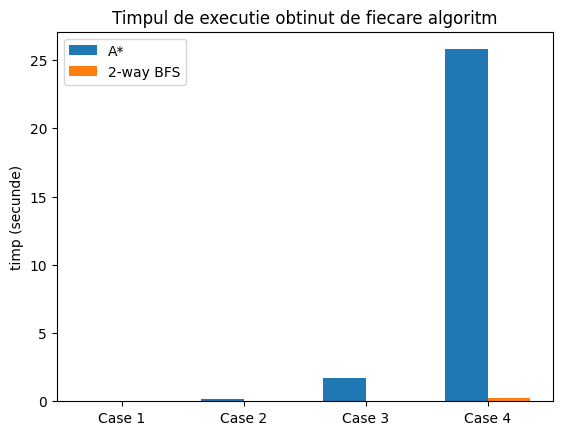

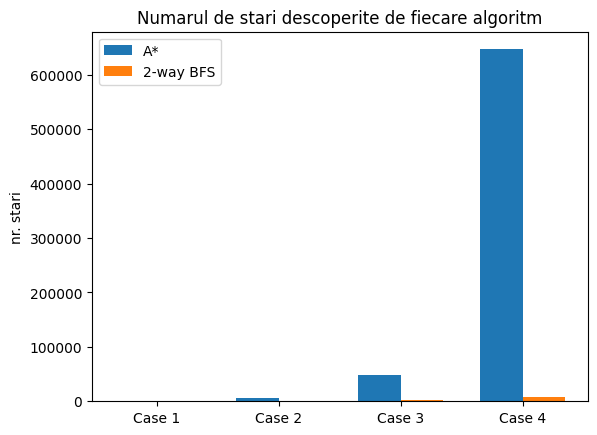

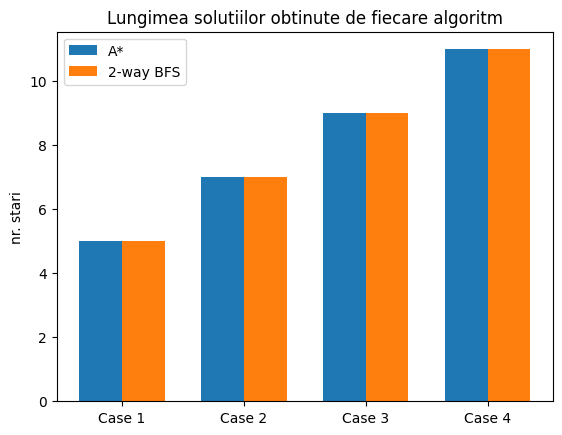

In [55]:
create_bar_chart(
    np.array([[astar_results[0][i], bfs_results[0][i]] for i in range(4)]),
    'timp (secunde)',
    'Timpul de executie obtinut de fiecare algoritm'
)

create_bar_chart(
    np.array([[astar_results[1][i], bfs_results[1][i]] for i in range(4)]),
    'nr. stari',
    'Numarul de stari descoperite de fiecare algoritm'
)

create_bar_chart(
    np.array([[astar_results[2][i], bfs_results[2][i]] for i in range(4)]),
    'nr. stari',
    'Lungimea solutiilor obtinute de fiecare algoritm'
)

Din rezultatele obtinute se observa clar faptul ca pentru rezolvarea pocket cube algoritmul de bfs bidirectional este cu mult mai eficient decat A*.
Acest rezultat nu este surprinzator avand in vedere faptul ca euristica pe care am folosit-o nu este cea mai eficienta euristica posibila, iar algoritmul folosit ar fi trebuit sa foloseasca mai degraba IDA* pentru ca A* genereaza un arbore al starilor foarte mare, lucru care se vede clar din al doilea bar chart.
De asemenea observam ca indiferent de algoritm solutia obtinuta are mereu aceeasi lungime, insa de notat ca pentru cazurile 3 si 4 solutiile au fost diferite pentru cei doi algoritmi, cum se poate vedea din rularea celulelor de mai sus.

In [124]:
from math import sqrt, log
from random import choice


N = 'N'
Q = 'Q'
PARENT = 'parent'
MOVES = 'moves'


def init_node(parent = (None, None)):
    return {N: 0, Q: 0, PARENT: parent, MOVES: {}}


def select_move(node, c):
    N_node = node[N]
    best_a = -1
    best_max = -1000
    for a in node[MOVES]:
        N_a = node[MOVES][a][N]
        Q_a = node[MOVES][a][Q]
        val = Q_a / N_a + c * sqrt(2 * log(N_node) / N_a)
        if best_max < val:
            best_max = val
            best_a = a
    return best_a


def is_final(state: Cube):
    return (state.state == state.goal_state).all()


def mcts(start: Cube, budget, c, h):
    start_time = time.perf_counter()
    states = 1
    tree = init_node()
    goal_node = None
    for _ in range(budget):
        state = start
        node = tree

        while len(node[MOVES]) == 6:
            move = select_move(node, c)
            state = state.move(move)
            node = node[MOVES][move]
        
        move = choice([move for move in Move if move not in node[MOVES]])
        state = state.move(move)
        node[MOVES][move] = init_node((node, move))
        node = node[MOVES][move]
        states += 1
        
        if is_final(state):
            goal_node = node
            break
        
        reward = -h(state.state)
        limit = 14
        while not is_final(state) and limit > 0:
            move = choice([move for move in Move])
            state = state.move(move)
            reward = max(reward, -h(state.state))
            limit -= 1
        
        while node is not None:
            node[N] += 1
            node[Q] += reward
            node = node[PARENT][0]
        
    if goal_node is None:
        return time.perf_counter() - start_time, states, None
    
    path = []
    while goal_node is not None:
        path.append(goal_node[PARENT][1])
        goal_node = goal_node[PARENT][0]
    
    return time.perf_counter() - start_time, states, path[-2::-1]

La algoritmul MCTS, pentru ca folosirea euristicii sa aiba sens am ales sa folosesc -h(state) pentru a nu fi nevoie sa modific direct euristicta.
Pentru euristica h2 voi folosi o euristica inadmisibila care extinde euristica h1 incercand sa calculeze distanta manhattan pentru a pozitiona, dar si orienta, fiecare cubulet in pozitia corecta.

In [125]:
def h2(state):
    val = 0
    for corner in list(product([0, 1], repeat=3)):
        corner_indexes = CORNER_TO_INDEX[corner]
        colors = tuple(state[i] for i in corner_indexes)
        if colors not in COLOR_TO_INDEX:
            colors = tuple(sorted(colors))
            val += 4
        actual = INDEX_TO_CORNER[COLOR_TO_INDEX[colors]]
        val += hamming_distance(corner, actual)
    return val / 4

In [134]:
def mcts_median(cube: Cube, budget, c, h, runs = 20):
    elapsed_time = 0
    states = 0
    solution_length = 0
    wins = 0
    
    for _ in range(runs):
        e, s, sol = mcts(cube, budget, c, h)
        elapsed_time += e
        states += s
        if sol is not None:
            solution_length += len(sol)
            wins += 1
    
    return elapsed_time / runs, states / runs, (solution_length / wins if wins > 0 else 15), wins / runs

Pentru a testa performantele algoritmului MCTS vom rula pentru fiecare din cele 4 teste toate combinatiile posibile de parametri de cate 20 de ori:
- euristici: `manhattan_distance` sau `h2`
- C: 0.5, 0.1
- buget: 1000, 5000, 10000, 20000

Pentru fiecare combinatie vom pastra ca date:
- timpul mediu de rulare
- numarul mediu de stari generate in arbore
- lungimea medie a solutiei gasite
- rata de succes

Nota: Pentru timpul mediu de rulare am considerat toate 20 rularile, nu doar pe cele terminate cu succes. Am ales sa calculez asa, deoarece consider ca are mai mult sens sa masuram in functie de timpul care ne asteptam sa dureze o singura rulare.

In [142]:
mcts_results = [{}, {}, {}, {}]

cases = [Cube(tests.case1), Cube(tests.case2), Cube(tests.case3), Cube(tests.case4)]
for i in range(4):
    cube = cases[i]
    print(f'Using test case {i + 1}')
    for h in [manhattan_distance, h2]:
        h_str = 'h1' if h == manhattan_distance else 'h2'
        for c in [0.5, 0.1]:
            for budget in [1000, 5000, 10000, 20000]:
                print(f'Running MCTS with {h_str}, C = {c}, budget = {budget}')
                elapsed_time, states, solution_length, solve_percentage = mcts_median(cube, budget, c, h)
                print(f'Average time: {elapsed_time}')
                print(f'Discovered states: {states}')
                print(f'Solution_length: {solution_length}')
                print(f'Solve percentage: {solve_percentage}')
                print()
                mcts_results[i][(h_str, c, budget)] = (elapsed_time, states, solution_length, solve_percentage)


Using test case 1
Running MCTS with h1, C = 0.5, budget = 1000
Average time: 0.47740837080054915
Discovered states: 999.5
Solution_length: 5.0
Solve percentage: 0.05

Running MCTS with h1, C = 0.5, budget = 5000
Average time: 1.9879825541982428
Discovered states: 3837.2
Solution_length: 5.0
Solve percentage: 0.3

Running MCTS with h1, C = 0.5, budget = 10000
Average time: 2.939973585595726
Discovered states: 5632.85
Solution_length: 5.0
Solve percentage: 0.55

Running MCTS with h1, C = 0.5, budget = 20000
Average time: 7.861507597946911
Discovered states: 14422.95
Solution_length: 5.0
Solve percentage: 0.3

Running MCTS with h1, C = 0.1, budget = 1000
Average time: 0.4695805188035592
Discovered states: 877.0
Solution_length: 5.666666666666667
Solve percentage: 0.15

Running MCTS with h1, C = 0.1, budget = 5000
Average time: 2.487608697995893
Discovered states: 4013.15
Solution_length: 5.0
Solve percentage: 0.2

Running MCTS with h1, C = 0.1, budget = 10000
Average time: 5.7569378394488

Pe masina mea aceasta rulare a durat `127 de minute`.
In urma rularii am fost dezamagit sa vad din rezultatele printate ca pentru cazurile de test 3 si 4, niciun algoritm nu a reusit sa genereze vreodata o solutie.
Din acest motiv, vom analiza mai in detaliu doar pentru primele 2 cazuri de test.
Am decis sa folosesc urmatoarea metoda pentru a evalua calitatea unui algoritm:
- creeam un plan 2D pentru fiecare caz de test unde vom aseza toti algoritmi ca un singur punct.
- axa ox reprezinta rata de succes al algoritmului, iar axa oy reprezinta timpul de executie.
- cautam algoritimii care se situeaza cat mai in stanga planului, iar apoi cat mai in jos
  - Dorim algoritmul cu cea mai buna rata de succes, iar apoi care este cel mai rapid.

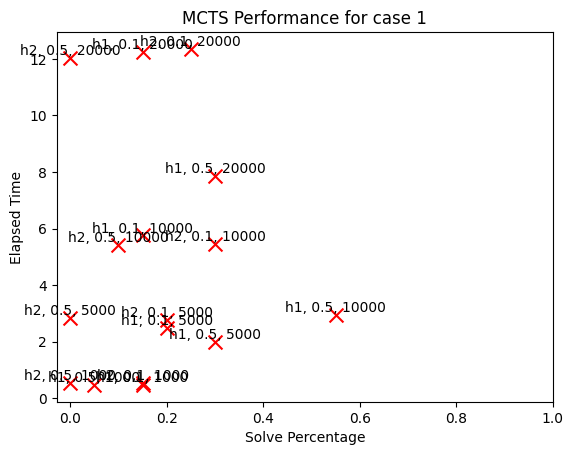

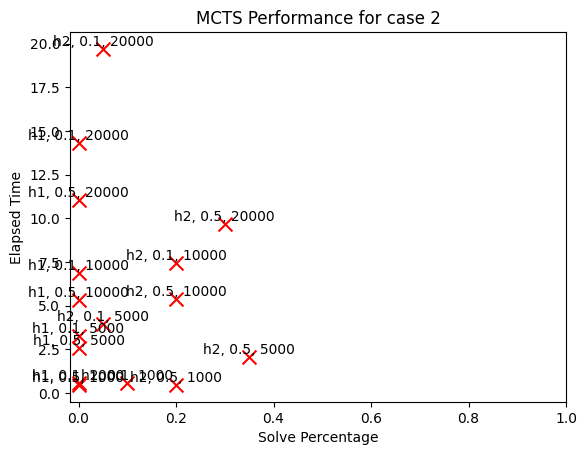

In [153]:
for i in range(2):
    for k, v in mcts_results[i].items():
        h_str, c, budget = k
        avg_time, _, _, succ_rate = v
        plt.scatter(succ_rate, avg_time, color='red', marker='x', s=100)
        plt.text(succ_rate, avg_time, f'{h_str}, {c}, {budget}', ha='center', va='bottom')
        
    plt.xlabel('Solve Percentage')
    plt.ylabel('Elapsed Time')
    plt.title(f'MCTS Performance for case {i + 1}')

    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.show()

Fiecare varianta diferita de algoritm `mcts` o putem descrie printr-un tuplu `(h, c, budget)` reprezentand euristica, constanta C si bugetul folosit.
Pentru primul test observam faptul cel mai mult succes l-a avut `(h1, 0.5, 10000)`. Mi s-a parut initial destul de surprinzator acest rezultat pentru ca m-as fi asteptat ca `(h1, 0.5, 20000)` sa aiba rata de succes mult mai mare. Cauza ar putea fi faptul ca euristica `h1` intoarce rezultate intr-un interval destul de mic, iar arborele de stari ajunge sa se indeparteze de solutia buna dupa un timp.
Pentru al doilea test am fost foarte surprins sa vad ca cea mai buna rata de succes l-a avut `(h2, 0.5, 5000)`.  `(h2, 0.5, 20000)` se apropie ca rata de succes si probabil ar depasi `(h2, 0.5, 5000)` pentru mai multe rulari. Faptul ca euristica `h2` se mai bine decat `h1` pe acest test este posibil sa fie cauzata de faptul ca `h2` intoarce rezultate intr-un interval mult mai mare, astfel ca solutiile mai bune primesc un reward relativ mai mare decat in cazul `h1`.

In continuare actualizam bar chart-ul cu A* si 2-way bfs pentru cazurile de test 1 si 2 cu cei mai buni algoritmi mcts.

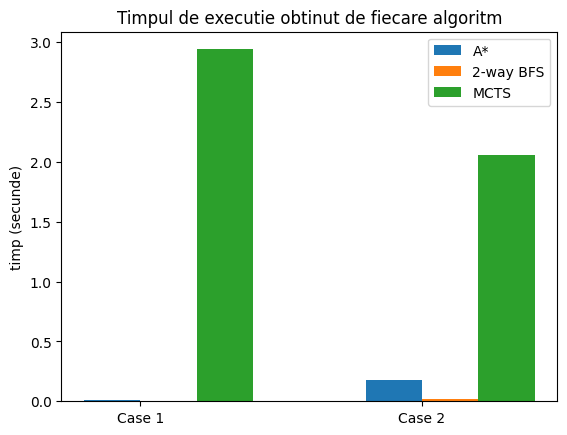

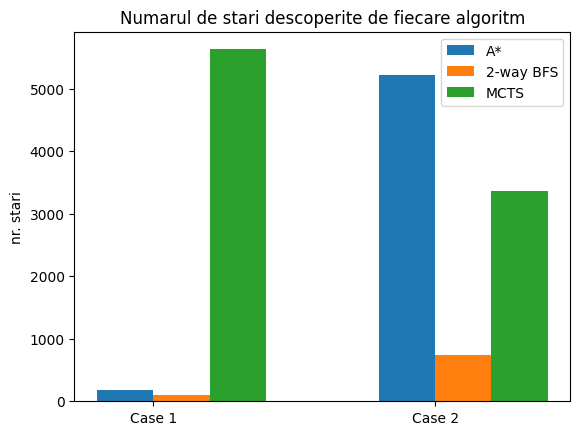

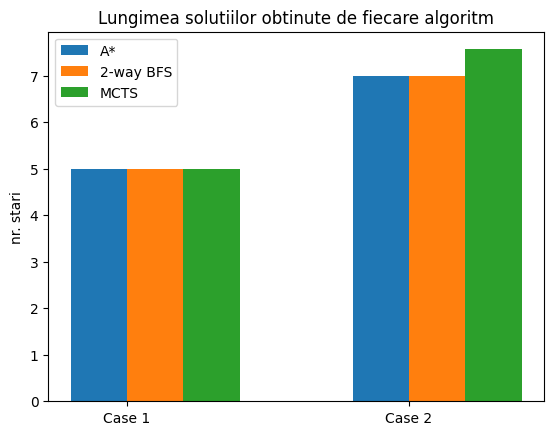

In [161]:
def create_bar_chart_2(data, ylabel, title):
    case_labels = ['Case 1', 'Case 2']
    algorithm_labels = ['A*', '2-way BFS', 'MCTS']

    _, ax = plt.subplots()
    bar_width = 0.2
    bar_positions = np.arange(len(case_labels))

    for i in range(len(algorithm_labels)):
        ax.bar(bar_positions + i * bar_width, data[:, i], bar_width, label=algorithm_labels[i])

    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.set_xticks(bar_positions + bar_width / 2)
    ax.set_xticklabels(case_labels)

    ax.legend()

    plt.show()

create_bar_chart_2(
    np.array([
        [astar_results[0][0], bfs_results[0][0], mcts_results[0][('h1', 0.5, 10000)][0]],
        [astar_results[0][1], bfs_results[0][1], mcts_results[1][('h2', 0.5,  5000)][0]],
    ]),
    'timp (secunde)',
    'Timpul de executie obtinut de fiecare algoritm'
)

create_bar_chart_2(
    np.array([
        [astar_results[1][0], bfs_results[1][0], mcts_results[0][('h1', 0.5, 10000)][1]],
        [astar_results[1][1], bfs_results[1][1], mcts_results[1][('h2', 0.5,  5000)][1]],
    ]),
    'nr. stari',
    'Numarul de stari descoperite de fiecare algoritm'
)

create_bar_chart_2(
    np.array([
        [astar_results[2][0], bfs_results[2][0], mcts_results[0][('h1', 0.5, 10000)][2]],
        [astar_results[2][1], bfs_results[2][1], mcts_results[1][('h2', 0.5,  5000)][2]],
    ]),
    'nr. stari',
    'Lungimea solutiilor obtinute de fiecare algoritm'
)

Din bar chart-ul actualizat putem trage urmatoarele concluzii:
- MCTS are nevoie de mai mult timp relativ cu A* si 2-way BFS pentru a gasi o solutie.
- MCTS descopera mai putine stari fata de A*, dar mai multe decat 2-way BFS cu cat problema este mai mare
- MCTS poate genera solutii mai lungi decat A* sau 2-way BFS.

In concluzie, in speranta ca nu am gresit eu ceva in implementarea algoritmului, rezultatele sunt destul de dezamagitoare. Ma astept ca implementarea cu pattern database sa fie cea mai eficienta, intrucat am vazut ca este cea recomandata in literatura de specialitate pentru aceasta problema.

Cream o functie pentru construirea catalogului. Apoi ne definim euristica `h3`. Am creat si functia `h3_improved` care intoarce 8 pentru starile care nu apar in `CATALOG` in loc sa foloseasca o euristica complementara. Am luat aceasta decizie, deoarece euristica pe care o folosesc intoarce de obicei rezultate mici, iar in cazul in care este folosita in `h3` avem nevoie de valori relativ mai mari.

In [205]:
def build_catalog(max_dist = 7):
    catalog = {}
    max_dist = min(max_dist, 14)
    
    start = Cube(scrambled=False)
    queue = [start]
    catalog[tuple(start.state)] = 0
    
    for dist in range(1, max_dist + 1):
        print(f'Generating level {dist}')
        next_queue = []
        while queue:
            node = queue.pop(0)
            for _, neigh in get_neighbours(node):
                neigh_state_hash = tuple(neigh.state)
                if neigh_state_hash in catalog:
                    continue
                next_queue.append(neigh)
                catalog[neigh_state_hash] = dist
        queue = next_queue
    
    return catalog

In [206]:
print('Generating catalog entries')
start_time = time.perf_counter()
CATALOG = build_catalog(7)
print(f'{len(CATALOG)} entries in {time.perf_counter() - start_time} seconds.')

def h3(state):
    state_hash = tuple(state)
    if state_hash in CATALOG:
        return CATALOG[state_hash]
    return manhattan_distance(state)


def h3_improved(state):
    state_hash = tuple(state)
    if state_hash in CATALOG:
        return CATALOG[state_hash]
    return 8

Generating catalog entries
Generating level 1
Generating level 2
Generating level 3
Generating level 4
Generating level 5
Generating level 6
Generating level 7
44971 entries in 1.7035172079922631 seconds.


Testam noile euristici cu A* si MCTS. Pentru MCTS vom alege `C = 0.5`, pentru ca a avut cele mai bune rezultate la etapa anterioara, si `budget = 20000` in speranta ca va maximiza rata de succes.

In [176]:
print('Running A* with h3 euristic\n')
astar_h3_results = ([], [], [])

elapsed_time, states, solution = astar(Cube(tests.case1), h3)
astar_h3_results[0].append(elapsed_time)
astar_h3_results[1].append(states)
astar_h3_results[2].append(len(solution))
print('Testcase 1:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = astar(Cube(tests.case2), h3)
astar_h3_results[0].append(elapsed_time)
astar_h3_results[1].append(states)
astar_h3_results[2].append(len(solution))
print('Testcase 2:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = astar(Cube(tests.case3), h3)
astar_h3_results[0].append(elapsed_time)
astar_h3_results[1].append(states)
astar_h3_results[2].append(len(solution))
print('Testcase 3:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = astar(Cube(tests.case4), h3)
astar_h3_results[0].append(elapsed_time)
astar_h3_results[1].append(states)
astar_h3_results[2].append(len(solution))
print('Testcase 4:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

Running A* with h3 euristic

Testcase 1:
Elapsed time: 0.003062749980017543
Discovered states: 26
Solution: [<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>]
Testcase 2:
Elapsed time: 0.08783441700506955
Discovered states: 2028
Solution: [<Move.U: 2>, <Move.F: 1>, <Move.Up: 5>, <Move.Rp: 3>, <Move.Up: 5>, <Move.Rp: 3>, <Move.F: 1>]
Testcase 3:
Elapsed time: 1.9231672910391353
Discovered states: 47063
Solution: [<Move.Rp: 3>, <Move.Up: 5>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>, <Move.Rp: 3>, <Move.F: 1>, <Move.Up: 5>, <Move.Fp: 4>]
Testcase 4:
Elapsed time: 31.97818866604939
Discovered states: 746036
Solution: [<Move.U: 2>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>, <Move.Rp: 3>, <Move.Fp: 4>, <Move.R: 0>, <Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.F: 1>]


In [213]:
print('Running MCTS with h3, C = 0.5, budget = 20000\n')
mcts_h3_results = ([], [], [], [])

elapsed_time, states, solution_length, solve_percentage = mcts_median(Cube(tests.case1), 20000, 0.5, h3, 10)
mcts_h3_results[0].append(elapsed_time)
mcts_h3_results[1].append(states)
mcts_h3_results[2].append(solution_length)
mcts_h3_results[3].append(solve_percentage)
print('Testcase 1:')
print(f'Average time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution_length: {solution_length}')
print(f'Solve percentage: {solve_percentage}')
print()

elapsed_time, states, solution_length, solve_percentage = mcts_median(Cube(tests.case2), 20000, 0.5, h3, 10)
mcts_h3_results[0].append(elapsed_time)
mcts_h3_results[1].append(states)
mcts_h3_results[2].append(solution_length)
mcts_h3_results[3].append(solve_percentage)
print('Testcase 2:')
print(f'Average time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution_length: {solution_length}')
print(f'Solve percentage: {solve_percentage}')
print()

elapsed_time, states, solution_length, solve_percentage = mcts_median(Cube(tests.case3), 20000, 0.5, h3, 5)
mcts_h3_results[0].append(elapsed_time)
mcts_h3_results[1].append(states)
mcts_h3_results[2].append(solution_length)
mcts_h3_results[3].append(solve_percentage)
print('Testcase 3:')
print(f'Average time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution_length: {solution_length}')
print(f'Solve percentage: {solve_percentage}')
print()

elapsed_time, states, solution_length, solve_percentage = mcts_median(Cube(tests.case4), 20000, 0.5, h3, 5)
mcts_h3_results[0].append(elapsed_time)
mcts_h3_results[1].append(states)
mcts_h3_results[2].append(solution_length)
mcts_h3_results[3].append(solve_percentage)
print('Testcase 4:')
print(f'Average time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution_length: {solution_length}')
print(f'Solve percentage: {solve_percentage}')
print()


Running MCTS with h3, C = 0.5, budget = 20000

Testcase 1:
Average time: 12.08585950420238
Discovered states: 20001.0
Solution_length: 15
Solve percentage: 0.0

Testcase 2:
Average time: 11.557336878898786
Discovered states: 20001.0
Solution_length: 15
Solve percentage: 0.0

Testcase 3:
Average time: 11.823065474792383
Discovered states: 20001.0
Solution_length: 15
Solve percentage: 0.0

Testcase 4:
Average time: 11.796251524798572
Discovered states: 20001.0
Solution_length: 15
Solve percentage: 0.0



Pentru ca rezultatele au fost foarte dezamagitoare am decis sa rulez doar de 10 ori pentru primele 2 teste, respectiv de 5 ori pentru ultimele 2 tests.

Am verificat de mai multe ori functia `mcts`, dar nu am gasit o problema acolo, deci presupun ca problema este de fapt cu euristica `h3`, motiv pentru care am propus utilizarea euristicii tot admisibile `h3_improved` care nu mai foloseste euristica complementara `manhattan_distance`.

Nota: Nu am mai creat grafice pentru a compara acest algoritm pentru ca oricum nu a avut succes niciodata, fapt care se poate vedea din ce a printat celula de mai sus.

Problema cu `h3` este ca euristica complementara folosita, `manhattan_distance`, nu este suficient de buna, chiar daca este admisibila. `manhattan_distance` este folosita doar pentru stari in care stim sigur ca costul este cel putin 8, dar aceasta euristica intoarce maxim 6, deci stari care ar trebui sa primeasca un scor foarte mic, primesc de fapt un scor relativ mare. Pentru `h3_improved` doar intoarcem 8 pentru starile care nu se gasesc in catalog, deci clar este o evolutie de la `manhattan_distance`.

In [195]:
print('Running MCTS with h3_improved, C = 0.5, budget = 20000\n')
mcts_h3_improved_results = ([], [], [], [])

elapsed_time, states, solution_length, solve_percentage = mcts_median(Cube(tests.case1), 20000, 0.5, h3_improved)
mcts_h3_improved_results[0].append(elapsed_time)
mcts_h3_improved_results[1].append(states)
mcts_h3_improved_results[2].append(solution_length)
mcts_h3_improved_results[3].append(solve_percentage)
print('Testcase 1:')
print(f'Average time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution_length: {solution_length}')
print(f'Solve percentage: {solve_percentage}')
print()

elapsed_time, states, solution_length, solve_percentage = mcts_median(Cube(tests.case2), 20000, 0.5, h3_improved)
mcts_h3_improved_results[0].append(elapsed_time)
mcts_h3_improved_results[1].append(states)
mcts_h3_improved_results[2].append(solution_length)
mcts_h3_improved_results[3].append(solve_percentage)
print('Testcase 2:')
print(f'Average time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution_length: {solution_length}')
print(f'Solve percentage: {solve_percentage}')
print()

elapsed_time, states, solution_length, solve_percentage = mcts_median(Cube(tests.case3), 20000, 0.5, h3_improved)
mcts_h3_improved_results[0].append(elapsed_time)
mcts_h3_improved_results[1].append(states)
mcts_h3_improved_results[2].append(solution_length)
mcts_h3_improved_results[3].append(solve_percentage)
print('Testcase 3:')
print(f'Average time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution_length: {solution_length}')
print(f'Solve percentage: {solve_percentage}')
print()

elapsed_time, states, solution_length, solve_percentage = mcts_median(Cube(tests.case4), 20000, 0.5, h3_improved)
mcts_h3_improved_results[0].append(elapsed_time)
mcts_h3_improved_results[1].append(states)
mcts_h3_improved_results[2].append(solution_length)
mcts_h3_improved_results[3].append(solve_percentage)
print('Testcase 4:')
print(f'Average time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution_length: {solution_length}')
print(f'Solve percentage: {solve_percentage}')
print()

Running MCTS with h3_improved, C = 0.5, budget = 20000

Testcase 1:
Average time: 0.012159083402366377
Discovered states: 35.55
Solution_length: 5.0
Solve percentage: 1.0

Testcase 2:
Average time: 0.021003918649512343
Discovered states: 57.5
Solution_length: 7.0
Solve percentage: 1.0

Testcase 3:
Average time: 0.03252419379132334
Discovered states: 88.0
Solution_length: 9.0
Solve percentage: 1.0

Testcase 4:
Average time: 0.15190684795961715
Discovered states: 435.15
Solution_length: 11.1
Solve percentage: 1.0



Cu `h3_improved` avem rezultate extraordinar de bune! In primul rand, MCTS reuseste sa gaseasca o solutie mereu. In al doilea rand, nu pare sa genereze niciodata mai mult de 500 de stari, chiar si pentru cazul 4, deci ajunge foarte repede la o solutie buna. Rularea de 20 de ori pe fiecare test a durat doar cateva secunde si observam cum aceasta varianta MCTS este cu mult mai mult mai buna chiar si decat `A*` cu `h3`.

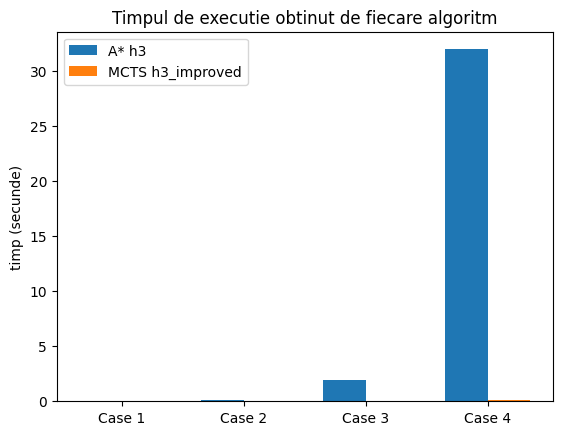

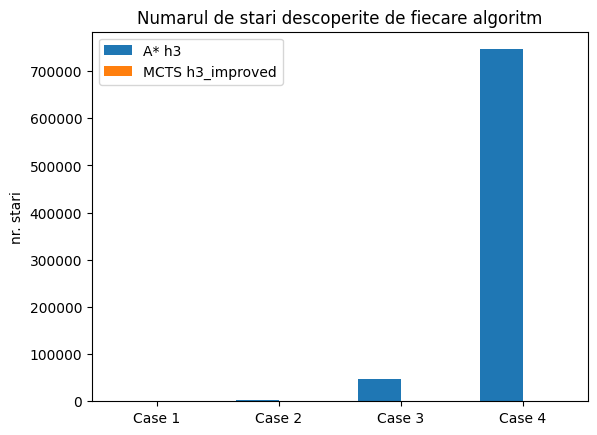

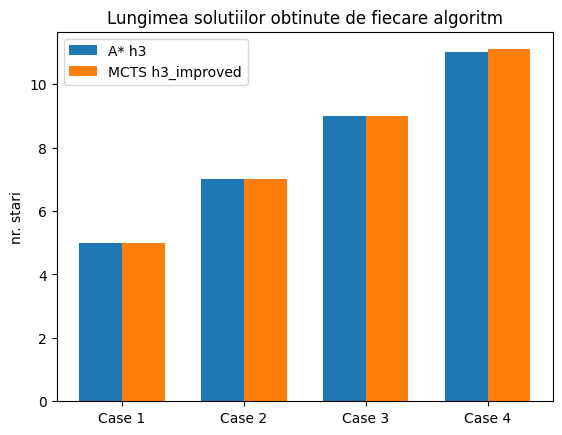

In [196]:
def create_bar_chart_3(data, ylabel, title):
    case_labels = ['Case 1', 'Case 2', 'Case 3', 'Case 4']
    algorithm_labels = ['A* h3', 'MCTS h3_improved']

    _, ax = plt.subplots()
    bar_width = 0.35
    bar_positions = np.arange(len(case_labels))

    for i in range(len(algorithm_labels)):
        ax.bar(bar_positions + i * bar_width, data[:, i], bar_width, label=algorithm_labels[i])

    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.set_xticks(bar_positions + bar_width / 2)
    ax.set_xticklabels(case_labels)

    ax.legend()

    plt.show()

create_bar_chart_3(
    np.array([[astar_h3_results[0][i], mcts_h3_improved_results[0][i]] for i in range(4)]),
    'timp (secunde)',
    'Timpul de executie obtinut de fiecare algoritm'
)

create_bar_chart_3(
    np.array([[astar_h3_results[1][i], mcts_h3_improved_results[1][i]] for i in range(4)]),
    'nr. stari',
    'Numarul de stari descoperite de fiecare algoritm'
)

create_bar_chart_3(
    np.array([[astar_h3_results[2][i], mcts_h3_improved_results[2][i]] for i in range(4)]),
    'nr. stari',
    'Lungimea solutiilor obtinute de fiecare algoritm'
)

Din acest bar chart se observa clar ca `MCTS` cu `h3_improved` este cea mai buna optiune, dar corect ar fi sa folosim A* tot cu `h3_improved`, deci sa vedem rezultatele.

In [198]:
print('Running A* with h3_improved euristic\n')
astar_h3_improved_results = ([], [], [])

elapsed_time, states, solution = astar(Cube(tests.case1), h3_improved)
astar_h3_improved_results[0].append(elapsed_time)
astar_h3_improved_results[1].append(states)
astar_h3_improved_results[2].append(len(solution))
print('Testcase 1:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = astar(Cube(tests.case2), h3_improved)
astar_h3_improved_results[0].append(elapsed_time)
astar_h3_improved_results[1].append(states)
astar_h3_improved_results[2].append(len(solution))
print('Testcase 2:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = astar(Cube(tests.case3), h3_improved)
astar_h3_improved_results[0].append(elapsed_time)
astar_h3_improved_results[1].append(states)
astar_h3_improved_results[2].append(len(solution))
print('Testcase 3:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = astar(Cube(tests.case4), h3_improved)
astar_h3_improved_results[0].append(elapsed_time)
astar_h3_improved_results[1].append(states)
astar_h3_improved_results[2].append(len(solution))
print('Testcase 4:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

Running A* with h3_improved euristic

Testcase 1:
Elapsed time: 0.0025026670191437006
Discovered states: 26
Solution: [<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>]
Testcase 2:
Elapsed time: 0.002068999980110675
Discovered states: 33
Solution: [<Move.Rp: 3>, <Move.Up: 5>, <Move.Fp: 4>, <Move.R: 0>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>]
Testcase 3:
Elapsed time: 0.002129542001057416
Discovered states: 55
Solution: [<Move.Rp: 3>, <Move.Up: 5>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>, <Move.Rp: 3>, <Move.F: 1>, <Move.Up: 5>, <Move.Fp: 4>]
Testcase 4:
Elapsed time: 0.009166624979116023
Discovered states: 219
Solution: [<Move.Up: 5>, <Move.Up: 5>, <Move.Fp: 4>, <Move.U: 2>, <Move.Fp: 4>, <Move.Fp: 4>, <Move.Rp: 3>, <Move.F: 1>, <Move.U: 2>, <Move.Rp: 3>, <Move.U: 2>]


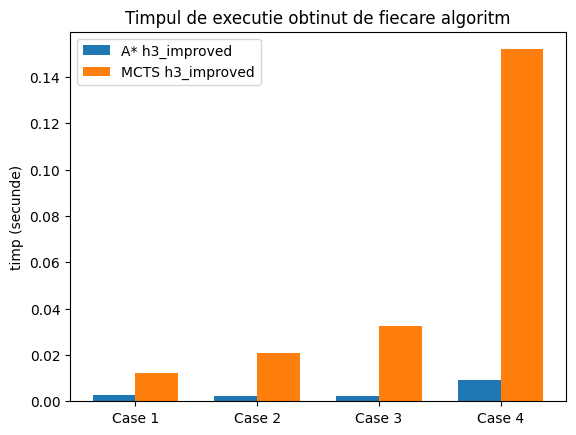

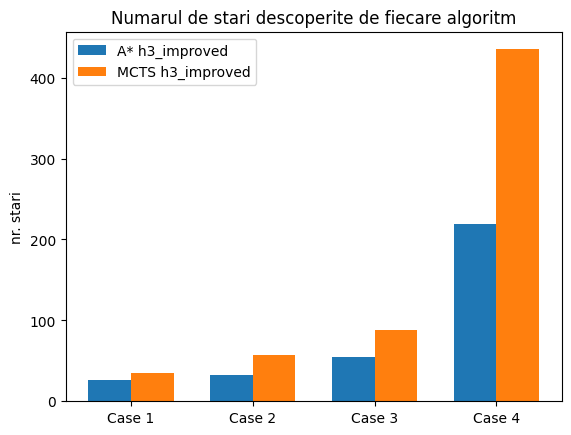

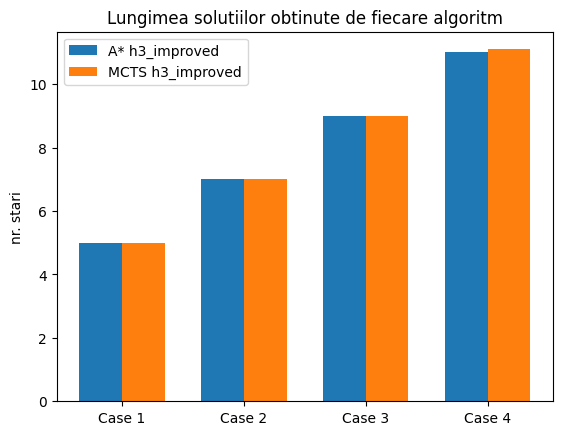

In [199]:
def create_bar_chart_3(data, ylabel, title):
    case_labels = ['Case 1', 'Case 2', 'Case 3', 'Case 4']
    algorithm_labels = ['A* h3_improved', 'MCTS h3_improved']

    _, ax = plt.subplots()
    bar_width = 0.35
    bar_positions = np.arange(len(case_labels))

    for i in range(len(algorithm_labels)):
        ax.bar(bar_positions + i * bar_width, data[:, i], bar_width, label=algorithm_labels[i])

    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.set_xticks(bar_positions + bar_width / 2)
    ax.set_xticklabels(case_labels)

    ax.legend()

    plt.show()

create_bar_chart_3(
    np.array([[astar_h3_improved_results[0][i], mcts_h3_improved_results[0][i]] for i in range(4)]),
    'timp (secunde)',
    'Timpul de executie obtinut de fiecare algoritm'
)

create_bar_chart_3(
    np.array([[astar_h3_improved_results[1][i], mcts_h3_improved_results[1][i]] for i in range(4)]),
    'nr. stari',
    'Numarul de stari descoperite de fiecare algoritm'
)

create_bar_chart_3(
    np.array([[astar_h3_improved_results[2][i], mcts_h3_improved_results[2][i]] for i in range(4)]),
    'nr. stari',
    'Lungimea solutiilor obtinute de fiecare algoritm'
)

In graficele de mai sus observam clar ca A* devine din ce in ce mai bun fata de MCTS cu cat cazul de test este mai complicat. In concluzie, pare ca MCTS nu este totusi un algoritm potrivit pentru aceasta problema.
Cred ca in incheiere ar avea sens sa comparam aceasta ultima versiune de A* cu rezultatul 2-way BFS

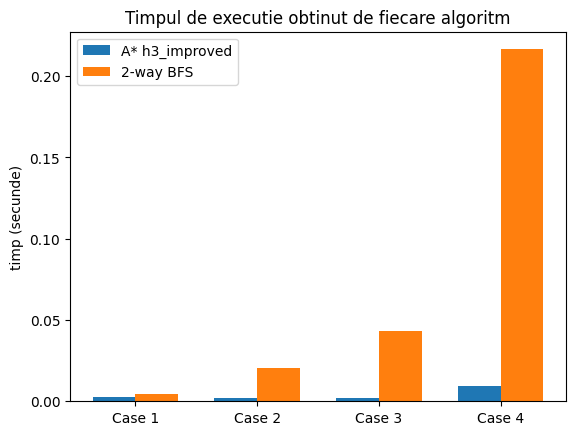

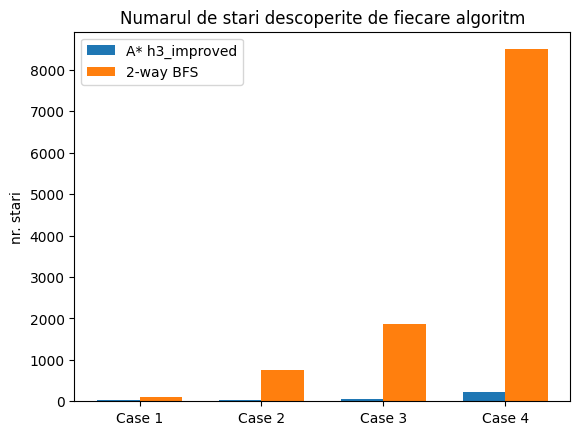

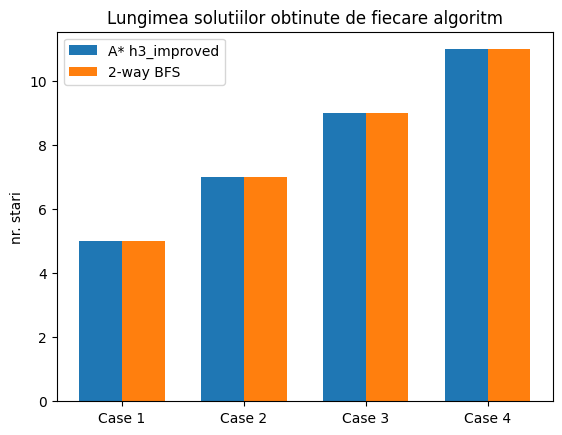

In [200]:
def create_bar_chart_3(data, ylabel, title):
    case_labels = ['Case 1', 'Case 2', 'Case 3', 'Case 4']
    algorithm_labels = ['A* h3_improved', '2-way BFS']

    _, ax = plt.subplots()
    bar_width = 0.35
    bar_positions = np.arange(len(case_labels))

    for i in range(len(algorithm_labels)):
        ax.bar(bar_positions + i * bar_width, data[:, i], bar_width, label=algorithm_labels[i])

    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.set_xticks(bar_positions + bar_width / 2)
    ax.set_xticklabels(case_labels)

    ax.legend()

    plt.show()

create_bar_chart_3(
    np.array([[astar_h3_improved_results[0][i], bfs_results[0][i]] for i in range(4)]),
    'timp (secunde)',
    'Timpul de executie obtinut de fiecare algoritm'
)

create_bar_chart_3(
    np.array([[astar_h3_improved_results[1][i], bfs_results[1][i]] for i in range(4)]),
    'nr. stari',
    'Numarul de stari descoperite de fiecare algoritm'
)

create_bar_chart_3(
    np.array([[astar_h3_improved_results[2][i], bfs_results[2][i]] for i in range(4)]),
    'nr. stari',
    'Lungimea solutiilor obtinute de fiecare algoritm'
)

In sfarsit A* este mai bun decat 2-way bfs! Euristica `h3_improved` este admisibila, iar acuratetea si timpul mic de calculare o face sa fie cu mult mai rapida decat 2-way bfs.
In continuare avem metode suplimentare pe care le putem folosi pentru imbunatatirea algoritmului:
- O euristica care calculeaza distanta manhattan tinand cont si de orientare, nu doar de pozitie;
- IDA*, in loc de A*;
- Generarea unui catalog mai larg pentru pattern database.

Generarea chiar a intregului catalog ar putea fi posibila in teorie:
- Pocket cube poate avea `3674160 de stari diferite`.
- In Python, un numar intreg ocupa `28 bytes`.
    - Cheia pentru fiecare intrare este formata din 24 de numere intregi, deci `24 * 28 bytes`.
    - Valoarea pentru fiecare intrare este un numar intreg, deci `28 bytes`.
- Dictionarele in Python adauga un overhead per intrare. Acest overhead difera in functie de implementarea interpretorului. Am gasit pe Google o aproximare la `136 bytes`.
- Deci pentru a calcula dimensiunea catalogului calculam: `3674160 * (24 * 28 + 28 + 136)`. Rezultatul este aproximativ egal cu `2.86 GB`.

In concluzie, catalogul intreg ar putea fi incarcat in memoria unui calculator modern fara probleme. Sa vedem daca aceasta teorie este corecta. Planuiesc sa generez cel putin 11 nivele din arborele format pentru construirea catalogului, pentru a asigura ca acopar toate cazurile de test.

In [209]:
BIG_CATALOG = build_catalog(11)
print(f'{len(BIG_CATALOG)} entries in {time.perf_counter() - start_time} seconds.')

Generating level 1
Generating level 2
Generating level 3
Generating level 4
Generating level 5
Generating level 6
Generating level 7
Generating level 8
Generating level 9
Generating level 10
Generating level 11
2801068 entries in 364.4881206250284 seconds.


In [210]:
def h4(state):
    state_hash = tuple(state)
    if state_hash in BIG_CATALOG:
        return BIG_CATALOG[state_hash]
    return 12

In [211]:
print('Running A* with h4 euristic\n')
astar_h4_results = ([], [], [])

elapsed_time, states, solution = astar(Cube(tests.case1), h4)
astar_h4_results[0].append(elapsed_time)
astar_h4_results[1].append(states)
astar_h4_results[2].append(len(solution))
print('Testcase 1:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = astar(Cube(tests.case2), h4)
astar_h4_results[0].append(elapsed_time)
astar_h4_results[1].append(states)
astar_h4_results[2].append(len(solution))
print('Testcase 2:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = astar(Cube(tests.case3), h4)
astar_h4_results[0].append(elapsed_time)
astar_h4_results[1].append(states)
astar_h4_results[2].append(len(solution))
print('Testcase 3:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

elapsed_time, states, solution = astar(Cube(tests.case4), h4)
astar_h4_results[0].append(elapsed_time)
astar_h4_results[1].append(states)
astar_h4_results[2].append(len(solution))
print('Testcase 4:')
print(f'Elapsed time: {elapsed_time}')
print(f'Discovered states: {states}')
print(f'Solution: {solution}')

Running A* with h4 euristic

Testcase 1:
Elapsed time: 0.0017213330138474703
Discovered states: 26
Solution: [<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>]
Testcase 2:
Elapsed time: 0.0017779999761842191
Discovered states: 33
Solution: [<Move.Rp: 3>, <Move.Up: 5>, <Move.Fp: 4>, <Move.R: 0>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>]
Testcase 3:
Elapsed time: 0.0020594160305336118
Discovered states: 45
Solution: [<Move.Rp: 3>, <Move.Up: 5>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>, <Move.Rp: 3>, <Move.F: 1>, <Move.Up: 5>, <Move.Fp: 4>]
Testcase 4:
Elapsed time: 0.002182958007324487
Discovered states: 52
Solution: [<Move.Up: 5>, <Move.Up: 5>, <Move.Fp: 4>, <Move.U: 2>, <Move.Fp: 4>, <Move.Fp: 4>, <Move.Rp: 3>, <Move.F: 1>, <Move.U: 2>, <Move.Rp: 3>, <Move.U: 2>]


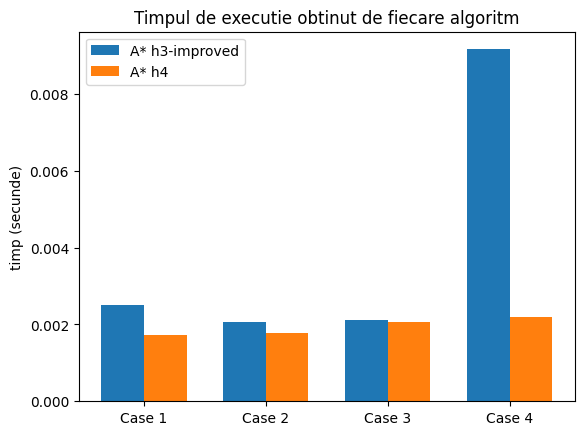

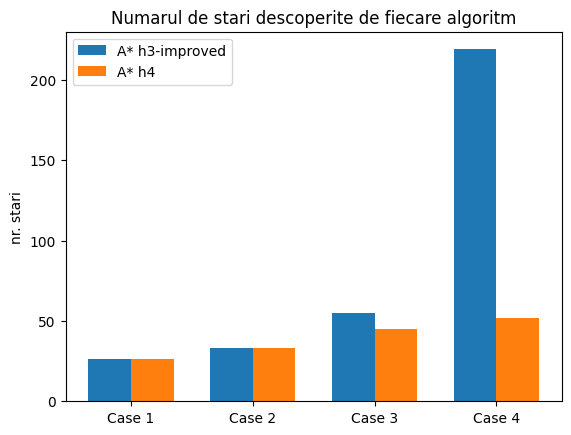

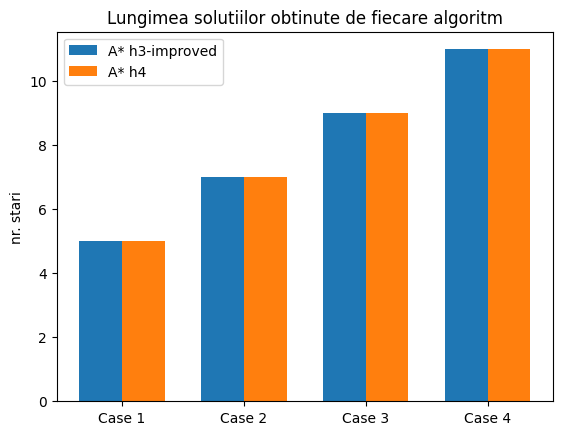

In [212]:
def create_bar_chart_3(data, ylabel, title):
    case_labels = ['Case 1', 'Case 2', 'Case 3', 'Case 4']
    algorithm_labels = ['A* h3-improved', 'A* h4']

    _, ax = plt.subplots()
    bar_width = 0.35
    bar_positions = np.arange(len(case_labels))

    for i in range(len(algorithm_labels)):
        ax.bar(bar_positions + i * bar_width, data[:, i], bar_width, label=algorithm_labels[i])

    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.set_xticks(bar_positions + bar_width / 2)
    ax.set_xticklabels(case_labels)

    ax.legend()

    plt.show()

create_bar_chart_3(
    np.array([[astar_h3_improved_results[0][i], astar_h4_results[0][i]] for i in range(4)]),
    'timp (secunde)',
    'Timpul de executie obtinut de fiecare algoritm'
)

create_bar_chart_3(
    np.array([[astar_h3_improved_results[1][i], astar_h4_results[1][i]] for i in range(4)]),
    'nr. stari',
    'Numarul de stari descoperite de fiecare algoritm'
)

create_bar_chart_3(
    np.array([[astar_h3_improved_results[2][i], astar_h4_results[2][i]] for i in range(4)]),
    'nr. stari',
    'Lungimea solutiilor obtinute de fiecare algoritm'
)

Rezultatele obtinute au sens. Pentru primele 3 cazuri de test ambele cataloage acopera gradul de amestecare al cubului. Diferenta se vede doar la testul 4 care este mult mai mare. Probabil ca similar pentru un catalog complet si un cub amestecat foarte bine am observa diferenta mari intre o euristica care foloseste catalogul complet si `h4`.